- время с последнего предложения для пользователя

- есть ли информация за n дней до скидки - для обоих компаний
- группировать по юзерам

- удаляем ли из кампании тех, у кого нет покупок # campaigns = campaigns[campaigns.customer_id.isin(set(receipts.customer_id))]

In [ ]:
# кол-во дней с последней покупки / кол-во дней с начала акции прошедших до 1 покупки

- нужно отобрать людей, которые сильно реагируют на скидку (при разбиении на группы будет большая прибыль)
- Интерес в том чтобы понять на каких людей мы можем повлиять – которые без воздействия не совершили бы покупку

Нужно совершать воздействие, когда
А) действие принесет пользу
Б) польза будет больше чем если не сорвешать воздействие

uY(xi)=E[Y∣X=xi,T=1]−E[Y∣X=xi,T=0]

In [4]:
# фит на датасете старой компании
# для предикта сформировать новую компанию
# Y - куплено в период компании, Х - куплено до компании

In [1]:
# # +число покупок
# # mean encoding города

# # +качество считается на 30 днях? добавить фичу по прошлой компании - насколько продолжал покупать

# кластеризовать юзеров

# как быть с 0

# # - стандартное отклонение

# метрика качества модели

# min/max

# # + убирать тех кто ничего не покупал (за последнее время)

In [1]:
import os

import pandas as pd
import numpy as np
import dask.dataframe as dd
import pickle
import json
import sklearn.base as skbase
import sklearn.pipeline as skpipe
import datetime
import matplotlib.pyplot as plt

import pylift

In [2]:
from typing import List, Tuple
import scipy as sp

In [3]:
def proportion_diff_interval(success: pd.Series, nobs: pd.Series, conf_level: float = 0.05):
    assert len(success) == 2 and len(nobs) == 2
    p = np.array(success) / np.array(nobs)
    z = sp.stats.norm.ppf(1.0 - conf_level)
    diff = p[1] - p[0]
    std_dev = np.sqrt(p[0] * (1.0 - p[0]) / nobs[0] + p[1] * (1.0 - p[1]) / nobs[1])
    pvalue = 2 * sp.stats.norm.cdf(-np.abs(diff) / std_dev)
    return diff, std_dev, pvalue, (diff - z * std_dev, diff + z * std_dev)


def response_uplift(
    data: pd.DataFrame,
    col_feature: str,
    col_target: str,
    col_treatment: str = 'treatment',
    conf_level: float = 0.05,
    verbose: bool = True,
    figsize: Tuple[int, int] = (10, 7),
    plot_type: str = 'default'
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    tmp = data.copy()
    tmp['tmp_response'] = list(map(int, tmp[col_target] > 0))
    
    response_pivot = tmp.pivot_table(
        values='tmp_response', index=[col_feature], columns=[col_treatment],
        aggfunc='sum'
    )
    
    clients_pivot = tmp.pivot_table(
        values='tmp_response', index=[col_feature], columns=[col_treatment],
        aggfunc='count'
    )
    
    means = list()
    stds = list()
    pvalues = list()
    chi2_pvalues = list()
    
    for segment in response_pivot.index:
        m, std, pvalue, _ = proportion_diff_interval(response_pivot.loc[segment, :], clients_pivot.loc[segment, :], conf_level=conf_level)
        means.append(m)
        stds.append(std)
        pvalues.append(pvalue)
        
        try:
            chi2_pvalue = chi2_contingency([response_pivot.loc[segment, :], clients_pivot.loc[segment, :]])[1]
        except:
            chi2_pvalue = -1.0
        
        chi2_pvalues.append(chi2_pvalue)
        
    report = pd.DataFrame(
        data={
            'diff': means, 
            'std': stds, 
            'p-value': pvalues,
            'chi2_p-value': chi2_pvalues,
            'count_0': clients_pivot.loc[:, 0],
            'count_1': clients_pivot.loc[:, 1],
            'response_0': response_pivot.loc[:, 0],
            'response_1': response_pivot.loc[:, 1]
        }, 
        index=list(response_pivot.index)
    )
    
    if verbose:
        plt.figure(figsize=figsize)
        if plot_type == 'default':
            plt.errorbar(
                x=response_pivot.index,
                y=means,
                yerr=np.array(stds) * sp.stats.norm.ppf(1.0 - conf_level),
                fmt='ok'
            )
        elif plot_type == 'bin':
            plt.errorbar(
                x=range(len(response_pivot.index)),
                y=means,
                yerr=np.array(stds) * sp.stats.norm.ppf(1.0 - conf_level),
                fmt='ok'
            )
            plt.xticks(
                range(len(response_pivot.index)),
                response_pivot.index,
                rotation=20
            )
        plt.show()

    return report, response_pivot, clients_pivot


In [4]:
# import sys
# sys.path.append('uplift-campaign/')

# import upcampaign.datalib as datalib
# import upcampaign.datalib.connection as connection
# import upcampaign.datalib.features.compute as fcompute
# # import upcampaign.model_utils as mu

In [5]:
import lightgbm as lgb
import causalml.metrics as cmetrics
import causalml.inference.meta.rlearner as rlearner
import causalml.inference.meta.xlearner as xlearner
import causalml.inference.meta.tlearner as tlearner

from sklearn.model_selection import train_test_split

In [6]:
ls data

campaigns.csv  customers.csv  receipts.parquet


In [7]:
data_root_path = 'data/'

In [8]:
campaigns = dd.read_csv(os.path.join(data_root_path, 'campaigns.csv')).compute()#.sample(0.01)
customers = dd.read_csv(os.path.join(data_root_path, 'customers.csv')).compute()#.sample(0.01)
receipts = dd.read_parquet(os.path.join(data_root_path, 'receipts.parquet/')).compute()#.sample(0.01)

In [9]:
len(campaigns), len(customers), len(receipts)

(500000, 2000000, 31741769)

In [10]:
def one_hot_encode(data: pd.DataFrame, cols: List[str] = None) -> pd.DataFrame:
    if cols is None:
        cols = data.columns
    result = pd.concat([data, dd.get_dummies(data[cols])], axis=1).drop(cols, axis=1)
    return result

In [11]:
customers = one_hot_encode(customers, cols=['location'])
customers = customers.drop('Unnamed: 0', axis=1)

In [12]:
customers.head()

,customer_id,age,location_Beauclair,location_Crows_perch,location_Hindarsfjall,location_Kaer_Trolde,location_Novigrad,location_Oxenfurt,location_Spikeroog
0,0,56,0,0,0,0,0,1,0
1,1,53,0,0,1,0,0,0,0
2,2,41,0,0,1,0,0,0,0
3,3,60,0,0,0,1,0,0,0
4,4,22,0,0,0,0,0,0,1


In [13]:
customers.nunique()

customer_id              2000000
age                           50
location_Beauclair             2
location_Crows_perch           2
location_Hindarsfjall          2
location_Kaer_Trolde           2
location_Novigrad              2
location_Oxenfurt              2
location_Spikeroog             2
dtype: int64

- Стоит отметить, что покупатель не приобретает фисштех больше одного раза в день

In [14]:
receipts = receipts.drop('purchase_sum', axis=1)

In [15]:
receipts.head()

,customer_id,date,purchase_amt,discount
26,26,0,12.125273,0
53,53,0,34.357035,0
56,56,0,8.695825,0
58,58,0,28.299046,0
64,64,0,32.547511,0


In [16]:
receipts.nunique()

customer_id      1998286
date                 250
purchase_amt    31616098
discount               2
dtype: int64

In [17]:
receipts = receipts.assign(target_profit=lambda d: (
    (d['discount'] == 0).astype(int) * (d['purchase_amt'] * (80 - 52)) + \
    (d['discount'] == 40).astype(int) * (d['purchase_amt'] * (80 - 52) - 40) - \
    (d['discount'] == 40).astype(int) * 1
))

In [18]:
receipts_agg = pd.DataFrame(index=set(receipts.customer_id))

In [19]:
def compute_campaign_purch_sum(df, camp_d_start):
    df['target_profit_total'] = \
       receipts[(receipts.date>=camp_d_start) & (receipts.date<camp_d_start+7)].groupby('customer_id')['target_profit'].sum()
    return df

In [20]:
def compute_purch_sum(df, camp_d_start, lag_list=[7,15,30,60]):
    for d in lag_list:
        df[f'puchase_amt_SUM_{d}d_before_campaign'] = \
        receipts[(receipts.date>=camp_d_start-d) & (receipts.date<camp_d_start)].groupby('customer_id')['purchase_amt'].sum()
    return df

In [21]:
def compute_purch_sum_rel_change(df):
    df['puchase_amt_SUM_30d_div_60d_before_campaign'] = df['puchase_amt_SUM_30d_before_campaign'] / df['puchase_amt_SUM_60d_before_campaign']
    df['puchase_amt_SUM_15d_div_30d_before_campaign'] = df['puchase_amt_SUM_15d_before_campaign'] / df['puchase_amt_SUM_30d_before_campaign']
    return df

In [22]:
def compute_purch_cnt(df, camp_d_start, lag_list=[7,15,30,60]):
    for d in lag_list:
        df[f'puchase_amt_CNT_{d}d_before_campaign'] = \
        receipts[(receipts.date>=camp_d_start-d) & (receipts.date<camp_d_start)].groupby('customer_id')['purchase_amt'].size()
    return df

In [23]:
def compute_purch_mean(df, camp_d_start, lag_list=[7,15,30,60]):
    for d in lag_list:
        df[f'puchase_amt_MEAN_{d}d_before_campaign'] = \
        receipts[(receipts.date>=camp_d_start-d) & (receipts.date<camp_d_start)].groupby('customer_id')['purchase_amt'].mean()
    return df

In [24]:
def compute_purch_mean_rel_change(df):
    df['puchase_amt_MEAN_30d_div_60d_before_campaign'] = df['puchase_amt_MEAN_30d_before_campaign'] / df['puchase_amt_MEAN_60d_before_campaign']
    df['puchase_amt_MEAN_15d_div_30d_before_campaign'] = df['puchase_amt_MEAN_15d_before_campaign'] / df['puchase_amt_MEAN_30d_before_campaign']
    return df

In [25]:
def compute_purch_min(df, camp_d_start, lag_list=[7,15,30,60]):
    for d in lag_list:
        df[f'puchase_amt_MIN_{d}d_before_campaign'] = \
        receipts[(receipts.date>=camp_d_start-d) & (receipts.date<camp_d_start)].groupby('customer_id')['purchase_amt'].min()
    return df

In [26]:
def compute_purch_max(df, camp_d_start, lag_list=[7,15,30,60]):
    for d in lag_list:
        df[f'puchase_amt_MAX_{d}d_before_campaign'] = \
        receipts[(receipts.date>=camp_d_start-d) & (receipts.date<camp_d_start)].groupby('customer_id')['purchase_amt'].max()
    return df

In [27]:
def compute_purch_min_div_max(df, camp_d_start, lag_list=[7,15,30,60]):
    for d in lag_list:
        df[f'puchase_amt_MIN_div_MAX_{d}d_before_campaign'] = df[f'puchase_amt_MIN_{d}d_before_campaign'] / df[f'puchase_amt_MAX_{d}d_before_campaign']
        
    return df

In [28]:
def compute_purch_std(df, camp_d_start, lag_list=[7,15,30,60]):
    for d in lag_list:
        df[f'puchase_amt_STD_{d}d_before_campaign'] = \
        receipts[(receipts.date>=camp_d_start-d) & (receipts.date<camp_d_start)].groupby('customer_id')['date'].std()
    return df

In [29]:
def compute_purch_last_day(df, camp_d_start):
    df['cnt_last_purch_days_before_campaign'] = \
       camp_d_start - receipts[receipts.date<camp_d_start].groupby('customer_id')['date'].max()
    return df

In [30]:
camp_day = 102
receipts_agg = compute_campaign_purch_sum(receipts_agg, camp_day)

receipts_agg = compute_purch_sum(receipts_agg, camp_day, lag_list=[7,15,30,60])
receipts_agg = compute_purch_cnt(receipts_agg, camp_day, lag_list=[7,15,30,60])

receipts_agg = compute_purch_mean(receipts_agg, camp_day, lag_list=[30,60])
receipts_agg = compute_purch_min(receipts_agg, camp_day, lag_list=[30,60])
receipts_agg = compute_purch_max(receipts_agg, camp_day, lag_list=[30,60])

receipts_agg = compute_purch_std(receipts_agg, camp_day, lag_list=[30,60])

receipts_agg = compute_purch_last_day(receipts_agg, camp_day)

receipts_agg = compute_purch_min_div_max(receipts_agg, camp_day, lag_list=[30,60])

receipts_agg = compute_purch_sum_rel_change(receipts_agg)
# receipts_agg = compute_purch_mean_rel_change(receipts_agg)

In [31]:
receipts_agg.head()

,target_profit_total,puchase_amt_SUM_7d_before_campaign,puchase_amt_SUM_15d_before_campaign,puchase_amt_SUM_30d_before_campaign,puchase_amt_SUM_60d_before_campaign,puchase_amt_CNT_7d_before_campaign,puchase_amt_CNT_15d_before_campaign,puchase_amt_CNT_30d_before_campaign,puchase_amt_CNT_60d_before_campaign,puchase_amt_MEAN_30d_before_campaign,...,puchase_amt_MIN_60d_before_campaign,puchase_amt_MAX_30d_before_campaign,puchase_amt_MAX_60d_before_campaign,puchase_amt_STD_30d_before_campaign,puchase_amt_STD_60d_before_campaign,cnt_last_purch_days_before_campaign,puchase_amt_MIN_div_MAX_30d_before_campaign,puchase_amt_MIN_div_MAX_60d_before_campaign,puchase_amt_SUM_30d_div_60d_before_campaign,puchase_amt_SUM_15d_div_30d_before_campaign
0,235.188978,NaN,12.028087,23.426074,64.498275,NaN,1.0,2.0,6.0,11.713037,...,4.872151,12.028087,13.803161,6.363961,19.398454,9.0,0.947614,0.352974,0.363205,0.513449
1,NaN,NaN,NaN,24.823082,46.727059,NaN,NaN,2.0,4.0,12.411541,...,7.633190,13.377143,14.270786,7.071068,16.309506,20.0,0.855634,0.534882,0.531236,NaN
2,NaN,39.13365,39.133650,39.133650,123.063061,2.0,2.0,2.0,5.0,19.566825,...,4.770558,34.363092,34.363092,2.121320,21.984085,2.0,0.138828,0.138828,0.317997,1.000000
3,519.533477,NaN,NaN,42.392725,107.439304,NaN,NaN,1.0,3.0,42.392725,...,32.065634,42.392725,42.392725,NaN,13.012814,24.0,1.000000,0.756395,0.394574,NaN
4,NaN,NaN,NaN,22.253255,41.160985,NaN,NaN,1.0,2.0,22.253255,...,18.907730,22.253255,22.253255,NaN,14.142136,16.0,1.000000,0.849661,0.540640,NaN


In [32]:
# receipts_agg[receipts_agg['cnt_last_purch_days_before_campaign'].isnull()]

In [33]:
receipts_agg[[c for c in receipts_agg.columns if (('_STD_' not in c) | ('_div_' not in c))]] = \
        receipts_agg[[c for c in receipts_agg.columns if (('_STD_' not in c) | ('_div_' not in c))]].fillna(0)

In [34]:
receipts_agg['is_campaign'] = 0

In [35]:
receipts_agg.loc[receipts_agg.index<500000, 'is_campaign'] = 1

In [36]:
receipts_agg.head()

,target_profit_total,puchase_amt_SUM_7d_before_campaign,puchase_amt_SUM_15d_before_campaign,puchase_amt_SUM_30d_before_campaign,puchase_amt_SUM_60d_before_campaign,puchase_amt_CNT_7d_before_campaign,puchase_amt_CNT_15d_before_campaign,puchase_amt_CNT_30d_before_campaign,puchase_amt_CNT_60d_before_campaign,puchase_amt_MEAN_30d_before_campaign,...,puchase_amt_MAX_30d_before_campaign,puchase_amt_MAX_60d_before_campaign,puchase_amt_STD_30d_before_campaign,puchase_amt_STD_60d_before_campaign,cnt_last_purch_days_before_campaign,puchase_amt_MIN_div_MAX_30d_before_campaign,puchase_amt_MIN_div_MAX_60d_before_campaign,puchase_amt_SUM_30d_div_60d_before_campaign,puchase_amt_SUM_15d_div_30d_before_campaign,is_campaign
0,235.188978,0.00000,12.028087,23.426074,64.498275,0.0,1.0,2.0,6.0,11.713037,...,12.028087,13.803161,6.363961,19.398454,9.0,0.947614,0.352974,0.363205,0.513449,1
1,0.000000,0.00000,0.000000,24.823082,46.727059,0.0,0.0,2.0,4.0,12.411541,...,13.377143,14.270786,7.071068,16.309506,20.0,0.855634,0.534882,0.531236,0.000000,1
2,0.000000,39.13365,39.133650,39.133650,123.063061,2.0,2.0,2.0,5.0,19.566825,...,34.363092,34.363092,2.121320,21.984085,2.0,0.138828,0.138828,0.317997,1.000000,1
3,519.533477,0.00000,0.000000,42.392725,107.439304,0.0,0.0,1.0,3.0,42.392725,...,42.392725,42.392725,0.000000,13.012814,24.0,1.000000,0.756395,0.394574,0.000000,1
4,0.000000,0.00000,0.000000,22.253255,41.160985,0.0,0.0,1.0,2.0,22.253255,...,22.253255,22.253255,0.000000,14.142136,16.0,1.000000,0.849661,0.540640,0.000000,1


In [37]:
data = receipts_agg.join(customers)

In [38]:
# data = pd.concat([data[data.is_campaign==1], 
#            data[data.is_campaign==0].sample(frac=0.1)
#           ], axis=0)

In [39]:
data = data.drop('customer_id', axis=1)

In [40]:
data.is_campaign.value_counts()

0    1498678
1     499608
Name: is_campaign, dtype: int64

In [41]:
col_target = 'target_profit_total'
col_treatment = 'is_campaign'

targ_cols = [col_target, col_treatment]
cols_features  = [c for c in data.columns if c not in targ_cols]

In [42]:
data.head()

,target_profit_total,puchase_amt_SUM_7d_before_campaign,puchase_amt_SUM_15d_before_campaign,puchase_amt_SUM_30d_before_campaign,puchase_amt_SUM_60d_before_campaign,puchase_amt_CNT_7d_before_campaign,puchase_amt_CNT_15d_before_campaign,puchase_amt_CNT_30d_before_campaign,puchase_amt_CNT_60d_before_campaign,puchase_amt_MEAN_30d_before_campaign,...,puchase_amt_SUM_15d_div_30d_before_campaign,is_campaign,age,location_Beauclair,location_Crows_perch,location_Hindarsfjall,location_Kaer_Trolde,location_Novigrad,location_Oxenfurt,location_Spikeroog
0,235.188978,0.00000,12.028087,23.426074,64.498275,0.0,1.0,2.0,6.0,11.713037,...,0.513449,1,56,0,0,0,0,0,1,0
1,0.000000,0.00000,0.000000,24.823082,46.727059,0.0,0.0,2.0,4.0,12.411541,...,0.000000,1,53,0,0,1,0,0,0,0
2,0.000000,39.13365,39.133650,39.133650,123.063061,2.0,2.0,2.0,5.0,19.566825,...,1.000000,1,41,0,0,1,0,0,0,0
3,519.533477,0.00000,0.000000,42.392725,107.439304,0.0,0.0,1.0,3.0,42.392725,...,0.000000,1,60,0,0,0,1,0,0,0
4,0.000000,0.00000,0.000000,22.253255,41.160985,0.0,0.0,1.0,2.0,22.253255,...,0.000000,1,22,0,0,0,0,0,0,1


In [43]:
# # посчитаем uplift в разрезе каждого из значений переменной f1 (средняя разность между целевыми и контрольными пользователями по показателю visit)
# # если бы различий не было, можно было бы избавиться от фактора
# # линии - доверительные интервалы

# _ = response_uplift(
#     data=data,
#     col_feature='location_Novigrad',
#     col_target=col_target,
#     col_treatment=col_treatment
# )

# fit part

In [44]:
fit_index, val_index = train_test_split(data.index, test_size=0.2, random_state=148)

In [45]:
_p_score_const = data.loc[fit_index, col_treatment].value_counts(normalize=True).loc[1]
_p_scores = pd.Series(data=_p_score_const, index=fit_index)

In [46]:
# lgb_params  = {'num_leaves': 30, 
#                'learning_rate': 0.15}

lgb_params = {}

In [47]:
# model_n1 = rlearner.BaseRRegressor(
#     learner=lgb.LGBMRegressor(**lgb_params),
#     control_name=0,
#     n_fold=4,
#     random_state=165
# )

# model_n1.fit(
#     X=data.loc[fit_index, cols_features].values,
#     treatment=data.loc[fit_index, col_treatment].values,
#     y=data.loc[fit_index, col_target].values,
#     p=_p_scores
# )

# _eval_data = data.loc[val_index, cols_features + [col_treatment, col_target]]
# _eval_data['score'] = model_n1.predict(_eval_data[cols_features])
# _eval_data = _eval_data[['score', col_treatment, col_target]]

In [48]:
model_n1 = xlearner.BaseXRegressor(
    learner=lgb.LGBMRegressor(**lgb_params),
    control_name=0,
)

model_n1.fit(
    X=data.loc[fit_index, cols_features].values,
    treatment=data.loc[fit_index, col_treatment].values,
    y=data.loc[fit_index, col_target].values,
    p=_p_scores
)

_p_scores = pd.Series(data=_p_score_const, index=val_index)

_eval_data = data.loc[val_index, cols_features + [col_treatment, col_target]]
_eval_data['score'] = model_n1.predict(_eval_data[cols_features], p=_p_scores)
_eval_data = _eval_data[['score', col_treatment, col_target]]

In [49]:
# model_n1 = tlearner.BaseTRegressor(
#     learner=lgb.LGBMRegressor(**lgb_params),
#     control_name=0,
# )


# model_n1.fit(
#     X=data.loc[fit_index, cols_features].values,
#     treatment=data.loc[fit_index, col_treatment].values,
#     y=data.loc[fit_index, col_target].values,
#     p=_p_scores
# )

# _eval_data = data.loc[val_index, cols_features + [col_treatment, col_target]]
# _eval_data['score'] = model_n1.predict(_eval_data[cols_features])
# _eval_data = _eval_data[['score', col_treatment, col_target]]

In [50]:
# model_n1 = pylift.TransformedOutcome(
#     data.loc[fit_index, cols_features + [col_treatment, col_target]],
#     col_treatment=col_treatment, col_outcome=col_target,
#     test_size=2
# )

# model_n1.fit()

# _eval_data = data.loc[val_index, cols_features + [col_treatment, col_target]]
# _eval_data['score'] = model_n1.model.predict(_eval_data[cols_features])
# _eval_data = _eval_data[['score', col_treatment, col_target]]

In [51]:
# np.percentile(_eval_data['score'], 5)

In [52]:
# np.percentile(_eval_data['score'], 95)

In [53]:
# plt.figure(figsize=(10, 6))
# plt.hist(_eval_data['score'], range=(-2, 2), bins=16)
# plt.show()

In [54]:
# _eval_data['score'].describe()

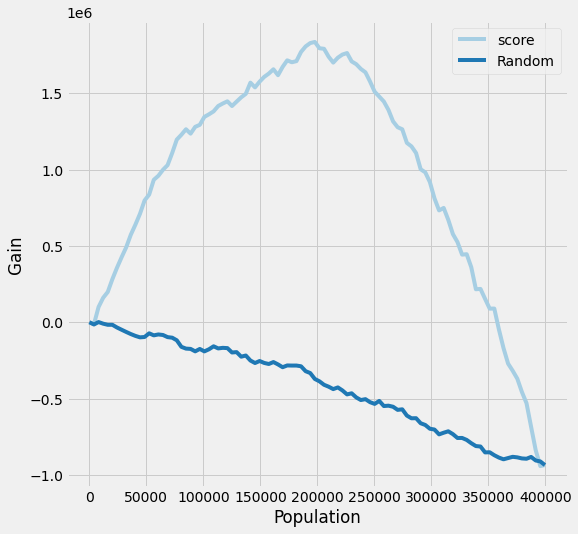

In [55]:
cmetrics.plot_gain(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col=col_target,
)

In [56]:
cmetrics.qini_score(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col=col_target,
)

score     1.481996e+00
Random   -4.223656e-15
dtype: float64

In [59]:
1.481996e+00

1.466021

In [57]:
tmp = pylift.TransformedOutcome(
    data.loc[fit_index, cols_features + [col_treatment, col_target]],
    col_treatment=col_treatment,
    col_outcome=col_target,
    test_size=2
)

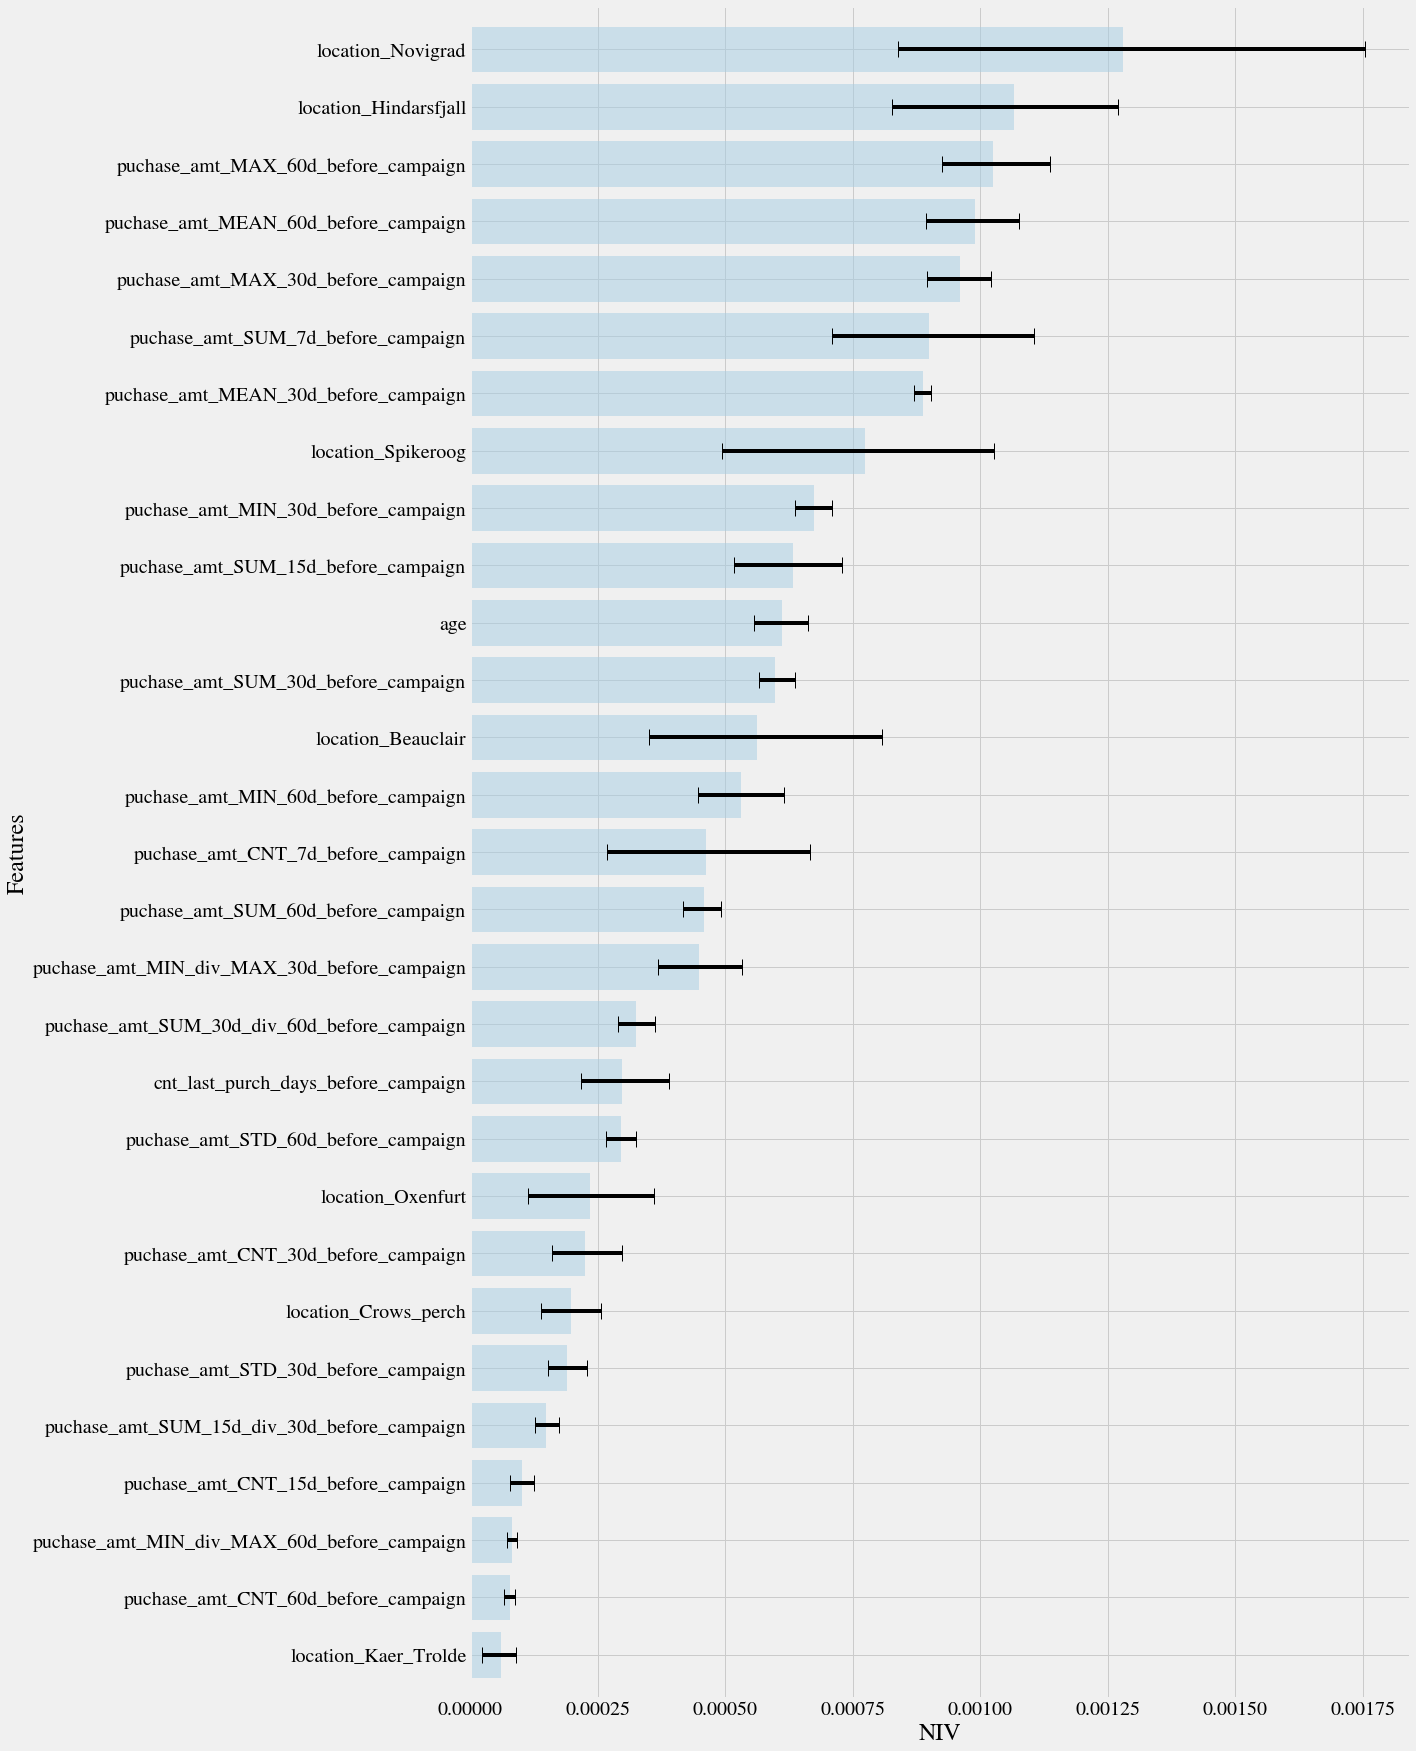

In [58]:
tmp.NIV(n_bins=10)

# fit

In [59]:
_p_score_const = data.loc[:, col_treatment].value_counts(normalize=True).loc[1]
_p_scores = pd.Series(data=_p_score_const, index=data.index)

In [60]:
# is_baseX = False

# model_n_pred = rlearner.BaseRRegressor(
#     learner=lgb.LGBMRegressor(**lgb_params),
#     control_name=0,
#     n_fold=4,
#     random_state=165
# )

# model_n_pred.fit(
#     X=data.loc[:, cols_features].values,
#     treatment=data.loc[:, col_treatment].values,
#     y=data.loc[:, col_target].values,
#     p=_p_scores
# )


In [61]:
is_baseX = True

model_n_pred = xlearner.BaseXRegressor(
    learner=lgb.LGBMRegressor(**lgb_params),
    control_name=0,
)

model_n_pred.fit(
    X=data.loc[:, cols_features].values,
    treatment=data.loc[:, col_treatment].values,
    y=data.loc[:, col_target].values,
    p=_p_scores
)

In [62]:
# is_baseX = False

# model_n_pred = tlearner.BaseTRegressor(
#     learner=lgb.LGBMRegressor(**lgb_params),
#     control_name=0,
# )


# model_n_pred.fit(
#     X=data.loc[:, cols_features].values,
#     treatment=data.loc[:, col_treatment].values,
#     y=data.loc[:, col_target].values,
#     p=_p_scores
# )


In [63]:
# is_baseX = False

# model_n_pred = pylift.TransformedOutcome(
#     data.loc[:, cols_features + [col_treatment, col_target]],
#     col_treatment=col_treatment, col_outcome=col_target,
#     test_size=2
# )

# model_n_pred.fit()

In [73]:
receipts.date.max()

249

# predict

In [65]:
_eval_data = pd.DataFrame(index=set(receipts.customer_id))

In [66]:
camp_day = 250
# _eval_data = compute_campaign_purch_sum(_eval_data, camp_day)

_eval_data = compute_purch_sum(_eval_data, camp_day, lag_list=[7,15,30,60])
_eval_data = compute_purch_cnt(_eval_data, camp_day, lag_list=[7,15,30,60])

_eval_data = compute_purch_mean(_eval_data, camp_day, lag_list=[30,60])
_eval_data = compute_purch_min(_eval_data, camp_day, lag_list=[30,60])
_eval_data = compute_purch_max(_eval_data, camp_day, lag_list=[30,60])
_eval_data = compute_purch_std(_eval_data, camp_day, lag_list=[30,60])

_eval_data = compute_purch_last_day(_eval_data, camp_day)

_eval_data = compute_purch_min_div_max(_eval_data, camp_day, lag_list=[30,60])

_eval_data = compute_purch_sum_rel_change(_eval_data)
# _eval_data = compute_purch_mean_rel_change(_eval_data)

In [67]:
_eval_data[[c for c in _eval_data.columns if (('_STD_' not in c) | ('_div_' not in c))]] = \
        _eval_data[[c for c in _eval_data.columns if (('_STD_' not in c) | ('_div_' not in c))]].fillna(0)

In [68]:
_eval_data = _eval_data.join(customers)

In [69]:
_eval_data = _eval_data.drop('customer_id', axis=1)

In [70]:
_eval_data.head()

,puchase_amt_SUM_7d_before_campaign,puchase_amt_SUM_15d_before_campaign,puchase_amt_SUM_30d_before_campaign,puchase_amt_SUM_60d_before_campaign,puchase_amt_CNT_7d_before_campaign,puchase_amt_CNT_15d_before_campaign,puchase_amt_CNT_30d_before_campaign,puchase_amt_CNT_60d_before_campaign,puchase_amt_MEAN_30d_before_campaign,puchase_amt_MEAN_60d_before_campaign,...,puchase_amt_SUM_30d_div_60d_before_campaign,puchase_amt_SUM_15d_div_30d_before_campaign,age,location_Beauclair,location_Crows_perch,location_Hindarsfjall,location_Kaer_Trolde,location_Novigrad,location_Oxenfurt,location_Spikeroog
0,0.000000,9.964590,20.769769,62.964857,0.0,1.0,2.0,7.0,10.384885,8.994980,...,0.329863,0.479764,56,0,0,0,0,0,1,0
1,10.517529,10.517529,10.517529,33.431073,1.0,1.0,1.0,3.0,10.517529,11.143691,...,0.314603,1.000000,53,0,0,1,0,0,0,0
2,34.315607,73.011893,73.011893,165.795167,1.0,2.0,2.0,5.0,36.505946,33.159033,...,0.440374,1.000000,41,0,0,1,0,0,0,0
3,0.000000,30.054258,30.054258,93.378358,0.0,1.0,1.0,3.0,30.054258,31.126119,...,0.321855,1.000000,60,0,0,0,1,0,0,0
4,0.000000,0.000000,0.000000,27.603203,0.0,0.0,0.0,2.0,0.000000,13.801601,...,0.000000,0.000000,22,0,0,0,0,0,0,1


In [71]:
if is_baseX: # BaseXRegressor
    _p_scores = pd.Series(data=_p_score_const, index=_eval_data.index)
    _eval_data['score'] = model_n_pred.predict(_eval_data, p=_p_scores)
else:
    _eval_data['score'] = model_n_pred.predict(_eval_data) 

In [72]:
# _eval_data

In [89]:
np.percentile(_eval_data['score'], 60)
# 0.921274544211426

3.8628949114181936

In [82]:
_eval_data.shape

(1998286, 30)

In [90]:
thr = 3.8628949114181936
# thr = 1

In [95]:
# out_df = _eval_data[(_eval_data['score']>=thr) & (_eval_data['cnt_last_purch_days_before_campaign']<60)]
out_df = _eval_data[(_eval_data['score']>=thr)]
out_df.shape

(799315, 30)

In [96]:
# 60perc thr, 640k - лучший результат

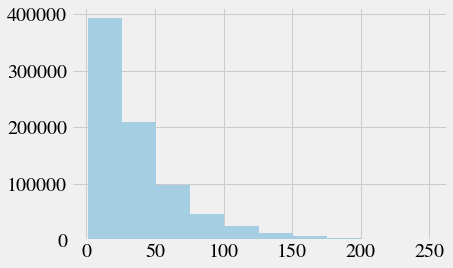

In [97]:
out_df['cnt_last_purch_days_before_campaign'].hist()

In [98]:
out_df = pd.DataFrame(out_df.index, columns=['customer_id'])

In [99]:
out_df.to_csv('submit.csv', index=False)

In [85]:
# _eval_data[_eval_data['score']>=thr][['customer_id']].to_csv('submit.csv', index=False)

# archive

In [53]:
(receipts['purchase_sum']/receipts['purchase_amt']).value_counts().index

Float64Index([80.0, 80.00000000000001, 79.99999999999999], dtype='float64')

In [54]:
receipts[receipts['purchase_sum']/receipts['purchase_amt']==80.00000000000001]

,customer_id,date,purchase_amt,discount,purchase_sum
1881,1881,0,7.391551,0,591.324108
1978,1978,0,13.321760,0,1065.740840
3029,3029,0,14.648189,0,1171.855155
3600,3600,0,15.086169,0,1206.893546
4502,4502,0,15.736323,0,1258.905867
...,...,...,...,...,...
1998880,1998880,249,15.779932,0,1262.394523
1999062,1999062,249,29.840009,0,2387.200757
1999677,1999677,249,15.395928,0,1231.674250
1999800,1999800,249,13.638075,0,1091.046036


In [59]:
receipts[receipts['purchase_sum']/receipts['purchase_amt']==79.99999999999999]['customer_id'].unique()

array([    391,     652,     806, ..., 1993889, 1996231, 1999192])

In [ ]:
# import sqlite3
# conn = sqlite3.connect(":memory:") 
# receipts.to_sql("receipts", conn, index=False)
# campaigns.to_sql("campaigns", conn, index=False)

# # qry = "SELECT * FROM receipts INNER JOIN campaigns WHERE receipts.customer_id=campaigns.customer_id"
# # rec_camp_merge_df = pd.read_sql_query(qry, conn)

# qry0 = "SELECT * FROM receipts INNER JOIN campaigns WHERE receipts.customer_id=campaigns.customer_id and receipts.date >= campaigns.date_start and receipts.date <=campaigns.date_end"
# rec_camp_merge_df_1 = pd.read_sql_query(qry0, conn)